# Convolutions

This notebook will contain my notes for convolutions.

#### Images

Let's start with images. Normally they consist of 3 channels (red, green, blue), a height, and a width. Each element of an image will have a pixel value between 0 and 255. Therefore, a given image can have the following dimensions:

$\text{Image} \in [0, ..., 255]^{C * H * W}$

For example, in a 64 x 64 image, you would have (64 * 64) pixels for each of the 3 channels, each taking values between 0 (black) and 255 ("full color", either "pure" red, green, or blue, depending on the channel).

PyTorch does $C * H * W$, or channels first, which was adopted out of a historical design that hasn't been changed. $H * W * C$ ends up actually running faster in practice. This is because in practice, we want to combine operations across channels (e.g., for a given pixel location, collapse all operations across all channels), but when channel ends up first, it leads to the values being located very far apart in memory, versus when channels are last, in which case they're normally closer in memory. This can be fixed with `memory_format = torch.channels_last`, but it's out of the scope of the class plus most of the out-of-the-box PyTorch models and tooling that works with images expects channel format to be included first, so therefore trying to use the $H * W * C$ format can screw up a lot of things.

##### Images can be very large
If we have, say, a 1024 x 1024 image, this is 1,048,576 pixels per channel, or 3,145,728 pixels across 3 channels. Each pixel value has to be represented by an 8-bit integer since it can take values between 0 and 255.

#### Images break fully-connected networks

Fully-connected networks do poorly with small transitions and fluctuations in the image.

##### Size is a concern
For example, let's say that you want to build a cat detector. Let's say that it takes 1024 x 1024 inputs across the 3 channels. In a traditional fully-connected network, we would do the operation $Wx + b$. This operation requires that we represent $x$ as a vector. This is already a concern, because for a 1024 x 1024 image, we would have a vector of length 1,048,576 * 3 = 3,145,728. If we want a weight matrix of size 512, that would mean having a weight matrix of 3,145,728 x 512, or 1,610,612,736 weights. If we use, say, 8-bit weights, that would mean that we'd need 12,884,901,888 bits, corresponding to 1.6GB. For just a single relatively small linear layer, we would need 1.6GB. Therefore, size alone makes this task impractical.

In addition, most of the image is actually not that useful for us. For example, do we really need every single pixel from a cat image to detect if something is a cat? A majority of the image is likely just the background. Even the parts of the image that are related, we don't need every single pixel, we just need enough to tell us what we want to know. Therefore, as it turns out, even if we wanted a fully-connected network, most of the weights would turn out to be pretty sparse.

In addition, the actual signal is "diffused" across the image - there's no one single pixel or point in the image that will tell us that something is a cat, but a "fuzzy view" of a region in the image can tell us if something is a cat. Therefore, having weights for every single pixel actually turns out to be counterproductive since having individual weights assumes that the part of the input corresponding to that weight is somehow informative, which in this case, since no single pixel will tell us if something is a cat, makes the weights not very useful (and frankly, likely not much different than noise).

##### Image variance

Let's say that our model learns how to detect cats. In a fully-connected network, it might learn that images are in the top-left corner of the image (maybe, say, it fires if the values in the square matrix location [15, 15] to [100, 100] are all filled in). What happens if you move the cat to a different part of the picture? Or what happens if you change the size of the cat? Or what happens if you change the shade of the cat (say, it's a white cat)? In those cases, since the weights of a fully-connected layer are matched explicitly to particular indices of the input vector, the fully-connected layer will be susceptible to the slightest changes in the image. The weights that we end up learning are very very specific to particular locations in the vector, which will correspond to particular locations in the image.

We need a representation of the image, therefore, that is invariant to changes in location, size, color, and any other ways that we can manipulate the image. Once we have this condensed representation of the image, where we get the same vector regardless of if, for example, a cat is in the top left corner or bottom right corner of an image, we can then pass that vector into the fully connected network.

#### Processing images in "patches" (i.e., convolutions)

##### Benefits of patching
We considered the case where we transform the image into a single vector and how that wouldn't work. As an alternative, we can consider processing the image in "patches".

Let's imagine that we have the following setup:
- $\text{Image} x \in [0, ..., 255]^{C x H x W}$
- Linear layer: $f : \R^N \rightarrow \R^D$

We can split the image into $M$ patches, each patch with shape $K * K * 3$ (for 3 color channels), and then run a single linear layer across all the patches (we would need a single linear layer, otherwise we can't communicate information across patches). That gives us the following setup:
$$\R^{CK^2} \rightarrow \R^{\frac{D}{M}}$$
This gives us $C * K^2 * \frac{D}{M}$ parameters total. This is in comparison to $C * H * W * D$ parameters in a regular linear layer. Since each patch takes a square chunk of the image, the number of parameters is approximately equal to:
$$C * H * W * \frac{D}{M} \approx \frac{C * H * W * D}{M^2}$$

We reduce the number of our parameters by an order of $M^2$.

##### Overlapping patching
If we cut up our images into patches, we can lose information across patches. We can solve this by slightly overlapping our patches.

What we do is we "slide" across an image, grab a patch, and take a linear transformation of it.

This is called a "convolution".

![Example of convolution](./../assets/conv_slide_1.png "Example of convolution")


##### Example convolution

Let's go through an example convolution. Let's say that we have the following matrix.

$$
\left[
\begin{matrix}
1 & 2 & 3\\
4 & 5 & 6\\
7 & 8 & 9
\end{matrix}
\right]
$$

Let's say that we want to take $2 * 2$ patches. This means that we'll take chunks of $2 * 2$ matrices and apply some calculation to get a "value" out of the $2 * 2$ matrix. Let's say that we just add the values together. That would mean that we slide the following matrix across each $2*2$ patch:
$$
\left[
\begin{matrix}
1 & 1\\
1 & 1
\end{matrix}
\right]
$$

When we slide this across, we first start with the following patch:
$$
\left[
\begin{matrix}
1 & 2\\
4 & 5
\end{matrix}
\right]
$$

Doing our matrix multiplication, we get
$$
\left[ \begin{array}{cc}
1 & 2 \\
4 & 5
\end{array} \right]
\text{x}
\left[ \begin{array}{cc}
1 & 1 \\
1 & 1
\end{array} \right]
=
12
$$

Doing this same operation across each $2*2$ window, we get the following matrix result:
$$
\left[
\begin{matrix}
12 & 16\\
24 & 28
\end{matrix}
\right]
$$

This is convolution. We take a linear operation (this case, our sliding windows, which we represented with a $2*2$ matrix) and apply it by sliding across our image. Our sliding windows are called **kernels** and we apply them across the images.

We can apply the convolution step mathematically here:

![Example of convolution](./../assets/conv_slide_2.png "Example of convolution")

Let's create a function to demonstrate how this works:

In [4]:
import torch

In [14]:
def perform_convolution(input_matrix: torch.Tensor, kernel: torch.Tensor) -> torch.Tensor:
    """Performs convolution step."""
    print(f"Input matrix: {input_matrix}\t Kernel: {kernel}")
    # Get the dimensions of the input matrix and the kernel
    input_matrix_shape = input_matrix.shape
    kernel_shape = kernel.shape

    # Get the dimensions of the output matrix
    output_matrix_shape = (input_matrix_shape[0] - kernel_shape[0] + 1, input_matrix_shape[1] - kernel_shape[1] + 1)

    # Initialize the output matrix
    output_matrix = torch.zeros(output_matrix_shape)

    # Perform the convolution
    for i in range(output_matrix_shape[0]):
        for j in range(output_matrix_shape[1]):
            output_matrix[i, j] = torch.sum(input_matrix[i:i + kernel_shape[0], j:j + kernel_shape[1]] * kernel)

    print(f"Output matrix: {output_matrix}")
    return output_matrix

In [7]:
input_matrix = torch.Tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
kernel = torch.Tensor([[1, 1], [1, 1]])
output = perform_convolution(input_matrix, kernel)
expected_output = torch.Tensor([[12, 16], [24, 28]])
assert torch.allclose(output, expected_output)

We can then have a "convolution layer" that takes a series of kernels, slides them across the input matrix, and then returns the result.

In [25]:
def perform_convolution_layer(input_matrix: torch.Tensor, kernels: list[torch.Tensor]) -> torch.Tensor:
    res = [
        perform_convolution(input_matrix, kernel)
        for kernel in kernels
    ]
    return torch.stack(res)

In [28]:
input_matrix = torch.Tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
kernels = [
    torch.Tensor([[1, 1], [1, 1]]),
    torch.Tensor([[0, 1], [0, 1]]),
    torch.Tensor([[1, 0], [1, 0]]),
    torch.Tensor([[1, 0], [0, 1]])
]
output = perform_convolution_layer(input_matrix, kernels)
print(output)
print(output.shape)

Input matrix: tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])	 Kernel: tensor([[1., 1.],
        [1., 1.]])
Output matrix: tensor([[12., 16.],
        [24., 28.]])
Input matrix: tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])	 Kernel: tensor([[0., 1.],
        [0., 1.]])
Output matrix: tensor([[ 7.,  9.],
        [13., 15.]])
Input matrix: tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])	 Kernel: tensor([[1., 0.],
        [1., 0.]])
Output matrix: tensor([[ 5.,  7.],
        [11., 13.]])
Input matrix: tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])	 Kernel: tensor([[1., 0.],
        [0., 1.]])
Output matrix: tensor([[ 6.,  8.],
        [12., 14.]])
tensor([[[12., 16.],
         [24., 28.]],

        [[ 7.,  9.],
         [13., 15.]],

        [[ 5.,  7.],
         [11., 13.]],

        [[ 6.,  8.],
         [12., 14.]]])
torch.Size([4, 2, 2])


This, in essence, is what a convolutional layer does in a neural network. If we have, for example, a $3 * 3$ input and 4 kernels of $2 * 2$, then our output from each kernel will be $2 * 2$, and so across 4 kernels, we'd expect an output of $2 * 2 * 4$.

##### Efficiency of the convolution operation

For our convolution layer, we save a lot on memory.

We don't need individual parameters for a large $(C * H * W) * D$ matrix like we would for a rectangular matrix in a linear layer.

Instead, we just need to know what are the parameters in each of the kernels that we slide across the image. We then use this same set of kernels and slide them across all the images that we see. As a result, the # of parameters is independent of image resolution altogether. Whether an image is larger or smaller only affects how many times you "slide" across an image; the actual parameters in each of the kernels remains the same.

As a result, this becomes very memory efficient.

If we take our case as before, with a $1024 * 1024$ image, we would need $5 * 10^{13}$ parameters, but with convolution with $3*3$ kernels, we need <500 parameters.

We slide each kernel across the image to get a result, then we add those results together to create a single result for that layer.

##### What do we lose with convolution?

Convolution greatly compresses our data. But what do we lose in doing so? What we lose is the ability for every input to directly see every output. In a typical $N*D$ rectangular matrix, every output is directly linked to every input somehow. In convolution, however, we aggregate the results of a "region" of the input and create the output. We, in essence, get a "receptive field" of our results, where a given pixel can only affect how that part of the image is interpreted, not how other parts of the image are interpreted.

The deeper that we get in the network, the larger the output's "receptive field" is, since it gets more of the aggregated sum of the layers before it. In practice, modern CNNs are deep enough and built in such a way that the final output has a receptive field large enough to encompass the whole image, so it can use information from the entire image. But, in the intermediate layers, these layers have more "local" views of the image, where they aggregate local chunks of the image, and downstream layers take these "aggregated local chunks" and create "chunk of chunks" representations, where they get a view of a larger part of the image by getting fuzzy representations of chunks of the image from the upstream layers. With CNNs, we lose the ability for every layer's outputs to have equal access to all the initial inputs (which we have in FFNNs), but we take a different approach where we ask each layer to create "chunks" of representation, and downstream layers take those chunks to create "chunk of chunks" representations.

##### Convolutions and invariances

FFNNs do poorly with image invariances (scaling, moving locations, resizing, etc.). CNNs, because they learn "chunk of chunks" representations, do quite well with these image shifts and changes.

##### Interpretations of convolution

There are generally three ways to interpret the convolution operation:
1. Convolution is an **efficient** image processer.
2. Convolution preserves **properties** of images.
3. Convolution is various **image filters**.

#### Building up a convolutional NN

What happens if we build our NNs with convolutional layers?

Let's say that we have the following normal setup for a NN:

$$\text{Linear} \rightarrow \text{ReLU} \rightarrow \text{Linear}$$

Let's swap out the linear layers for convolutional layers.

$$\text{Convolution} \rightarrow \text{ReLU} \rightarrow \text{Convolution}$$

##### Issue 1: Vanilla convolution shrinks inputs.
Because convolutional layers necessarily compress the image into a smaller representation, we end up losing information and making each downstream layer smaller than the previous one.

We can solve this with **padding**, where we pad the input with zeros along all sides to match the output size.

Padding gives us $p_w$ and $p_h$ (padding width and height) as new hyperparameters. These should always be equal to each other in order to avoid sliding the image. We have to reconsider the shapes of our inputs and outputs:

![Convolution with padding](./../assets/conv_slide_3.png "Convolution with padding")

We should always have $p_w$ such that $w = 2p_w + 1$, or twice the padding plus one equals the kernel width (same for the height). This also means that the kernel sizes should be odd numbers (which they normally are anyways) because having an even-sized kernel shape means that you can't have padding of a correct shape.

##### Issue 2: Vanilla CNNs get very slow as $C$, the number of channels, grows

**Primer on channels**

In each convolutional layer, we apply kernels to extract certain "features" of an image. Each kernel gets a result, and then we stack the results of each kernel's sliding into "channels", and pass the stack of channels to the next layer.

For example, let's say we have $1024 * 1024$ images with 3 channels. Let's also say that we have 32 kernels. Let's say that each kernel preserves size by having appropriate padding. That means that each kernel returns a result of shape $1024 * 1024$. Across 32 kernels, that means a result of shape $1024 * 1024 * 32$.

Let's say that the output of the first layer is this output of $1024 * 1024 * 32$. Let's say that in the next layer, we have 16 kernels with shape $3*3$. If we preserve the size of the image, each kernel will have a shape of $3 * 3 * 32$, as it collects $3*3$ chunks across all channels. Each kernel will return a result of shape $1024 * 1024$, meaning that our output from this layer is $1024 * 1024 * 16$.

Channels are crucial for CNNs, as they allow the network to learn more rich representations of features as well as supports hierarchical feature learning (i.e., learning "chunk of chunks").

**Computational cost of convolution**

The computational cost of a convolution step can be given by the following:
$$O(WHwhC_1C_2)$$

Where $W$ and $H$ are the width and height of the input, $w$ and $h$ are the width and height of the kernels, and $C_1$ and $C_2$ are the number of input and output channels respectively.

**Problem of too many channels**

As our computation continues, we can progressively have more and more channels, which slows down our computation. Since our cost is $O(WHwhC_1C_2)$, if we want to hold the cost constant, we can decrease our image width and height in order to add more kernels (and thus support more channels and therefore more feature extractors).

**Solving the problem of slow computation through striding**

We can do this through **striding**, where we take a certain step size as we stride across the image. By default, we take a step size of 1 when sliding across the image, but that doesn't have to be the case. We can, for example, take a step size of 2. This has the benefit of reducing the output image size since we're "skipping" parts of the image. It also has the benefit of expanding the "receptive field" of the downstream layers since the input chunks are no longer overlapping. This is best done by adding striding to later convolutional layers, since those layers want to learn "higher-order representations" and have larger receptive fields.

![Convolution with stride](./../assets/conv_slide_4.png "Convolution with stride")

##### What if the CNN is still too slow?

If the CNN is still too slow, we can apply two more tricks:

**Group convolution**

We can split the input channels that we have into groups, and we'll only run certain kernels on certain input channels. That way, our computation is grouped.

If we split our input channels into *g* groups, this transforms the computational complexity of our problem.

$$O(WHwhC_1C_2) \rightarrow O(\frac{WHwhC_1C_2}{g})$$
$$O(C_1C_2) \rightarrow O(\frac{C_1C_2}{g})$$

In [29]:
def perform_group_convolution(input_tensor: torch.Tensor, out_channels: int, kernel_size: int, groups: int) -> torch.Tensor:
    """Performs group convolution."""
    in_channels = input_tensor.shape[1]
    conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size, groups=groups, bias=False)
    
    # Initialize the kernel weights to some values for demonstration purposes
    torch.nn.init.normal_(conv.weight, mean=0.0, std=1.0)
    
    output = conv(input_tensor)
    return output

In [32]:
# Example input tensor with 3 channels, 1 batch, and 5x5 spatial dimensions
input_tensor = torch.randn(1, 3, 5, 5)

# Perform group convolution with 6 output channels, 2x2 kernel size, and 3 groups
output_tensor = perform_group_convolution(input_tensor, out_channels=6, kernel_size=2, groups=3)

print(f"Input Tensor Shape: {input_tensor.shape}")
print(f"Output Tensor Shape: {output_tensor.shape}")
# print("Output Tensor:", output_tensor)

Input Tensor Shape: torch.Size([1, 3, 5, 5])
Output Tensor Shape: torch.Size([1, 6, 4, 4])


An extreme case of group convolution is **depthwise convolution**, where $C_1 = C_2 = g$, or the input channels and output channels are equal and each channel gets their own group. This reduces the computational cost.

$$O(WHwhC_1C_2) \rightarrow O(WHwhC_1)$$

However, this can't apply any processing across channels, so you need to add a $1*1$ convolutional layer right after in order to "collapse" across the different channels and process across those channels. The $1*1$ convolution has a runtime of $O(WHC_1C_2)$. Therefore, splitting the convolution operation as a depthwise convolution plus $1*1$ convolution changes our runtime to:

$$O(WHwhC_1C_2) \rightarrow O(WHwhC_1) + O(WHC_1C_2)$$

This means transforming our convolution layer from
$$\text{Convolution} \rightarrow \text{ReLU}$$

To

$$\text{Depthwise convolution} \rightarrow \text{1 x 1 convolution} \rightarrow \text{ReLU}$$

This ends up speeding up the computation of downstream convolution layers and is often applied in deep networks.

##### Hyperparameters in convolution

We have the following possible hyperparameters in convolution:
- Strides
- Kernel size
- Output channels
- Groups
- Padding

For each of these, there are recommended best practices:
- Strides: $s_w = s_h \in \{1, 2\}$
- Kernel size: $w = h \in \{1, 3\}$
- Output channels: $C_2 = C_1s_w = C_1s_h$ (powers of 2)
    - Keeps computation constant: $O(WHwhC_1C_2)$
- Groups: ignore, only use if you know what you're doing
- Padding: $p_w = \frac{w-1}{2}, p_h = \frac{h-1}{2}$

#### Building convolutional networks

A convolution "block" normally consists of
- Convolution
- Nonlinearity
- Normalization and residuals (for deeper networks)

We normally have a setup like this:
$$\text{Convolution block} \rightarrow \text{Convolution block} \rightarrow \text{Linear output layer}$$

## Convolutions in PyTorch

Now let's actually implement convolutions in PyTorch.

In [35]:
net = torch.nn.Conv2d(
    in_channels=1, # 1-d input (i.e., not 3-channel input, like RGB).
    out_channels=16, # 16 channels output.
    kernel_size=3, # 3 x 3 kernels.
    stride=1,
    padding=1 # (3-1)/2 = 1
)

Let's pass in some input. Let's create a random tensor, with batch size of 1, that has only 1 channel. Let's use 28 x 28 since this is the size of the popular MNIST dataset.

In [36]:
x = torch.randn(
    1, # 1 batch.
    1, # 1 channel.
    28, # 28 x 28 image.
    28
)

Let's feed the input through the network and see the result:

In [38]:
print(f"Input shape: {x.shape}")
y = net(x)
print(f"Output shape: {y.shape}")

Input shape: torch.Size([1, 1, 28, 28])
Output shape: torch.Size([1, 16, 28, 28])


Convolution did not change the size of the output (28 x 28) since we added padding. We see that there are now 16 channels in the output instead of 1.

If we now add striding, we'll see that the output is cut in half:

In [39]:
net = torch.nn.Conv2d(
    in_channels=1, # 1-d input (i.e., not 3-channel input, like RGB).
    out_channels=16, # 16 channels output.
    kernel_size=3, # 3 x 3 kernels.
    stride=2,
    padding=1 # (3-1)/2 = 1
)

In [40]:
print(f"Input shape: {x.shape}")
y = net(x)
print(f"Output shape: {y.shape}")

Input shape: torch.Size([1, 1, 28, 28])
Output shape: torch.Size([1, 16, 14, 14])


Now let's build it into a larger network.

In [42]:
class ConvNet(torch.nn.Module):
    """Convolutional neural network."""

    def __init__(self, layers=[16, 32, 64, 64], kernel_size=3, stride=1):
        super(ConvNet, self).__init__()
        cnn_layers = []
        c1 = 1 # 1 input channel
    
        # add convolutional layers
        for c2 in layers:
            padding = (kernel_size - 1) // 2
            cnn_layers.append(
                torch.nn.Conv2d(
                    in_channels=c1,
                    out_channels=c2,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding
                )
            )
            cnn_layers.append(torch.nn.ReLU())
            c1 = c2

        # add classification layer. We can do this in two ways, either averaging
        # the outputs of the last layer using a fully-connected layer or doing
        # a 1x1 convolution. Mathematically they are equivalent. Let's do
        # the 1x1 convolution, since doing the 1x1 convolution lets us
        # maintain the spatial locations of the features to the classification
        # layer.
        cnn_layers.append(
            torch.nn.Conv2d(
                in_channels=c1,
                out_channels=1, # 1 output class for now.
                kernel_size=1
            )
        )
        self.network = torch.nn.Sequential(*cnn_layers)
    
    def forward(self, x):
        return self.network(x)


For our classification layer, we could have also used a fully-connected layer instead of the 1x1 convolution. We would modify the last steps of our model definition to be like this:

```python
        self.conv_layers = torch.nn.Sequential(*cnn_layers)
        
        # fully connected layer
        self.fc = torch.nn.Linear(c1 * 64 * 64, 1)  # Assuming input size is 64x64
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)
        return x
```

What's the difference between the two? It lies mostly from the fact that having a linear layer requires that we flatten our convolutional layer. This means that we lose spatial structure in doing so.

When we do a 1x1 convolution, we get the following benefits:
- **Maintains Spatial Structure**: Since it operates across the depth of the input while maintaining the height and width, it preserves the spatial structure of the input.
- **Computational Efficiency**: It performs a linear combination of the input channels at each spatial location, which can be computationally efficient.
- **Spatial Features**: It allows the network to maintain and manipulate spatial features up to the final layer. This can be useful for tasks where spatial information is crucial, such as object detection or segmentation.

A fully-connected layer, in contrast, requires that we flatten the image. This is more OK in general **classification tasks** and are generally more flexible in terms of input size, especially since they don't care about spatial structure.

For our case, we can actually use either output and they'd give similar answers, but it's more computationally efficient to use the 1x1 convolution plus we preserve spatial structure, so we'll use that instead.

Let's create our network.

In [43]:
net = ConvNet()

In [44]:
print(net)

ConvNet(
  (network): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)


Let's review what are the output shapes at each step of the network. Let's assume that we're starting with the (28x28) inputs as in our example.

Our input is of shape (28 x 28 x 1) since it has one channel.

After the first layer, we get $(28 * 28 * 1) \rightarrow (28 * 28 * 16)$

After the second layer, we get $(28 * 28 * 16) \rightarrow (28 * 28 * 32)$

After the second layer, we get $(28 * 28 * 32) \rightarrow (28 * 28 * 64)$

After the second layer, we get $(28 * 28 * 64) \rightarrow (28 * 28 * 64)$

Then, after our 1x1 convolution, we get

After the second layer, we get $(28 * 28 * 64) \rightarrow (28 * 28 * 1)$

So the shape of our input is $(28 * 28 * 1)$, and the shape of our output is the same, $(28 * 28 * 1)$.

For a classification task, we can then take the 1x1 output and then apply a linear layer, such as:
```python
torch.nn.Linear(28*28, 1)
```

But for now, we'll just take an input and return the output CNN representation, to see what we can learn about the receptive field.


In [45]:
y = net(x)

In [46]:
print(f"Input shape: {x.shape}")
print(f"Output shape: {y.shape}")

Input shape: torch.Size([1, 1, 28, 28])
Output shape: torch.Size([1, 1, 28, 28])


Let's now see the receptive field of a given input. We can do so by passing in a NaN for part of the image and then seeing the result.

In [47]:
import matplotlib.pyplot as plt

In [48]:
x = torch.randn(1, 1, 28, 28)
x[0, 0, 10, 10] = float('NaN')
y = net(x)

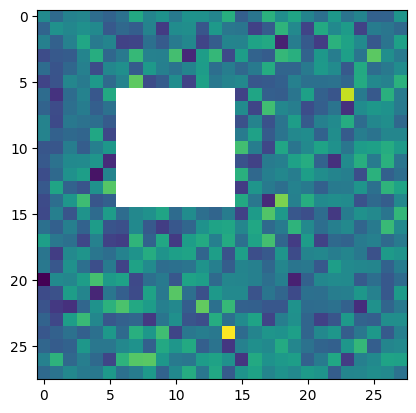

In [50]:
plt.imshow(y[0, 0].detach().numpy())
plt.show()

We can see that the input NaN "infects" certain areas of the downstream layer. Any element in the output that was affected at all by that one input pixel through the accumulation of different upstream layers is now marked in white, while unaffected outputs maintain their color. This tells us as a result which outputs are affected by the given input.

However, this tells us which outputs are affected by which input, and the receptive field would tell us which inputs affect a given output. This is the opposite of what we have (though knowing the above is still interesting), so now we can move on to compute the receptive field.

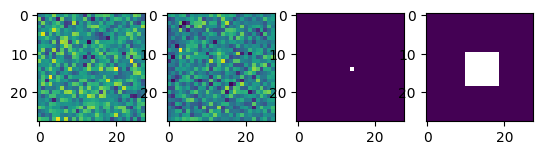

In [54]:
f, ax = plt.subplots(1, 4)

x = torch.randn(1, 1, 28, 28, requires_grad=True) # we have to backpropagate

# our input image
ax[0].imshow(x[0, 0].detach().numpy())
y = net(x)

# our output image
ax[1].imshow(y[0, 0].detach().numpy())

# create a new tensor the same shape as y. Doing it with 'new_zeros' copies the type and device location of y to z.
# In contrast, torch.zeros creates a tensor on the CPU by default.
z = y.new_zeros(y.shape)
z[0, 0, z.shape[2]//2, z.shape[3]//2] = float('NaN') # right in the middle of the tensor.

# sum all the elements of y*z and backpropagate
# given that it's all zeros except for the NaN values, the gradient will be
# nonzero only for the NaN values.
(y*z).sum().backward()

# we can plot our probe z to see where the NaN values are. We should see a
# white square in the middle of the image. This corresponds to the output pixel
# that we're interested in.
ax[2].imshow(z[0, 0].detach().numpy())


# now, since we run the backwards step, we can see the gradient of x. Since
# there is a NaN that we are backpropagating, we should see a gradient at that
# location is NaN and marked with a white square.

# as a result, we'll see the inputs in X that are affected by the NaN value
# in the output Y. This will tell us which pixels in the input image are
# affecting that particular output pixel.
ax[3].imshow(x.grad[0, 0].detach().numpy())
plt.show()

### Pooling

When we apply convolutions to patches of an image, what we're doing is applying a linear operation (represented by our matrix kernels) to the different patches of the image. However, we can generalize this so that instead of applying simply a linear operation, we can apply any function $f$ over our patches. This generalization is known as **pooling**.

for pooling, we'll have the following hyperparameters:
- Stride
- Kernel size
- Padding

These are the same hyperparameters that we had for our kernels, which makes sense given that pooling is just a generalization of the kernel operation.

Pooling is useful for the following reasons:
- It reduces the spatial dimensions of the inputs
- It reduces overfitting
- It provides translation invariance: small shifts in the input image won't significantly affect the results of the output layer.

#### Max pooling
Max pooling takes the given window and takes the max value in the window. For example:

$$
\text{max}\left(
\begin{matrix}
1 & 2\\
3 & 4\\
\end{matrix}
\right) \rightarrow 4
$$

This is a nonlinear operation that takes the max value in a given window. It is possible to have a network that is just a set of convolutions and max pooling layers since max pooling is a nonlinear operation. Max pooling is the most commonly used type of pooling. It highlights the most prominent features, such as edges and textures, in the feature maps.

In [56]:
# Example: 2x2 max pooling with stride 2
max_pool = torch.nn.MaxPool2d(kernel_size=2, stride=1)

# Input tensor
input_tensor = torch.tensor([[[[1, 3, 2, 4],
                               [5, 6, 1, 2],
                               [8, 7, 4, 3],
                               [2, 1, 6, 5]]]], dtype=torch.float32)

# Apply max pooling
output_tensor = max_pool(input_tensor)
print(f"Input shape: {input_tensor.shape}")
print(f"Output shape: {output_tensor.shape}")

Input shape: torch.Size([1, 1, 4, 4])
Output shape: torch.Size([1, 1, 3, 3])


##### Average pooling
Average pooling takes the average value in a window. For example:
$$
\text{average}\left(
\begin{matrix}
1 & 2\\
3 & 4\\
\end{matrix}
\right) \rightarrow 2.5
$$

Average pooling is less used than max pooling, and it is generally used when we want a smoothing effect over the input.

In [57]:
# Example: 2x2 average pooling with stride 2
avg_pool = torch.nn.AvgPool2d(kernel_size=2, stride=2)

# Input tensor
input_tensor = torch.tensor([[[[1, 3, 2, 4],
                               [5, 6, 1, 2],
                               [8, 7, 4, 3],
                               [2, 1, 6, 5]]]], dtype=torch.float32)

# Apply max pooling
output_tensor = avg_pool(input_tensor)
print(f"Input shape: {input_tensor.shape}")
print(f"Output shape: {output_tensor.shape}")

Input shape: torch.Size([1, 1, 4, 4])
Output shape: torch.Size([1, 1, 2, 2])


##### Related (but not the same): Global pooling
Global pooling is a type of pooling that is different from max pooling and average pooling. Global pooling is normally done in the last step of a network and removes the spatial dimension by collapsing a $H * W$ channel to a $1 * 1$ value. Therefore, it collapses a $C * H * W$ input to $C * 1 * 1$ output.

There are two types of global pooling:
- Global average pooling (GAP): computes the average of the $H*W$ values in a channel.
- Global max pooling (GMP): computes the max of the $H*W$ values in a channel.

This reduces the number of parameters in the last layer (as opposed to a fully-connected layer), reduces overfitting by reducing model complexity, and helps achieve spatial invariance since the feature map has to be summarized to a spatially-independent single value.

In [62]:
# Example: Global max pooling
global_max_pool = torch.nn.AdaptiveMaxPool2d((1, 1))

# Input tensor
input_tensor = torch.tensor([[[[1, 3, 2, 4],
                               [5, 6, 1, 2],
                               [8, 7, 4, 3],
                               [2, 1, 6, 5]]]], dtype=torch.float32)

# Apply global max pooling
output_tensor = global_max_pool(input_tensor)
print(f"Input shape: {input_tensor.shape}")
print(f"Output shape: {output_tensor.shape}") # reduces 4x4 to 1x1
print(f"Output tensor: {output_tensor}")

Input shape: torch.Size([1, 1, 4, 4])
Output shape: torch.Size([1, 1, 1, 1])
Output tensor: tensor([[[[8.]]]])


In [61]:
# Example: Global average pooling
global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))

# Input tensor
input_tensor = torch.tensor([[[[1, 3, 2, 4],
                               [5, 6, 1, 2],
                               [8, 7, 4, 3],
                               [2, 1, 6, 5]]]], dtype=torch.float32)

# Apply global average pooling
output_tensor = global_avg_pool(input_tensor)
print(f"Input shape: {input_tensor.shape}")
print(f"Output shape: {output_tensor.shape}") # reduces 4x4 to 1x1
print(f"Output tensor: {output_tensor}")

Input shape: torch.Size([1, 1, 4, 4])
Output shape: torch.Size([1, 1, 1, 1])
Output tensor: tensor([[[[3.7500]]]])


##### Difference between global pooling and max/average pooling
What are the differences between global pooling and max/average pooling? The key difference is when each is done.
- **Max/average pooling is done in the intermediate layers**. Its purpose is to reduce the size of the intermediate representations.
For example, let's say that we have a $64*64$ image with 3 channels and a $2*2* max pooling operation with stride=1. In that case:
    - Our inputs have shape $3 * 64 * 64$
    - Our outputs have shape $3 * 63 * 63$ (we apply max pooling across each channel separately and return the reshaped result)
- **Global pooling is done in the final layer**. Its purpose is to collapse the results along a spatial dimension.
    - Let's say that our input to the last layer has shape $32 * 64 * 64$, for a $64*64$ image across 32 input channels.
    - Our output after global pooling will have a shape of $32 * 1 * 1$.

#### Usage of pooling

Max and average pooling are no longer commonly used, as other structures have emerged. Max pooling still is sometimes used though as a nonlinearity layer.

Before, we would do:
$$\text{Convolution 3x3} \rightarrow \text{Max pooling} \rightarrow \text{ReLU} \rightarrow \text{Convoultion 1x1}$$

Now, in lieu of max pooling, we just use striding within the convolutions plus a ReLU nonlinearity, and then add global pooling at the end.

$$\text{Convolution} \rightarrow \text{ReLU} \rightarrow \text{Convolution} \rightarrow \text{ReLU} \rightarrow \text{Convolution} \rightarrow \text{Global average pooling}$$


### Design principles of convolutional networks

How can we build bigger and bigger convolutional networks?

##### Accounting for striding

We want to be able to add striding. This allows us to be able to skip inputs and reduce the dimensionality of our problem. We want to keep the computation constant in the network (so that we have more consistent training throughout the network, the model doesn't overfit to particular input sizes, and the model can be trained and run with more efficient parallel processing), so if we reduce the dimensionality of our inputs, we want a corresponding change to increase the number of channels. If we have a stride of length 2 (which is what is almost always the case), then this will cut our width and height in half, meaning that we should double the number of channels in response.

This ends up cutting our number of activations by a factor of 2.

$$C * W * H \rightarrow 2C * \frac{H}{2} * \frac{W}{2} \rightarrow \frac{C * W * H}{2}$$

This ends up not being good across every layer, since we strictly lose information while doing this.

Our solution for this is to expand the first layer. In most modern networks, we greatly expand the first layer. The first layer ends up being very very wide, as we represent our inputs with a lot of channels and then condense with striding later on.
- Channels: 64 - 96
- Large kernel size: 7 - 16: if we blow up a single kernel, we don't get much information, so we need a large kernel size for the first layer.
- Strided: 2 - 16

##### Keep kernels small
Except for the first layer, keep kernels small (use $1*1$ or $3*3$). Larger kernels are often a waste of computation. For example, you can get the effect of a $5*5$ kernel by applying 3 consecutive $3*3$ kernel layers, and those consecutive layers will be more expressive since they'll have nonlinearities (i.e., ReLUs) between them.

##### Repeat patterns
Create basic blocks for computation, i.e., a "Convolutional block". Something like this would suffice:

In [ ]:
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels=1, sizes=[16, 32, 64], kernel_sizes=[3, 1, 3]): # noqa
        layers = []
        # apply a 3x3 convolution with 16 output channels
        # then apply a 3x3 convolution with 32 output channels
        # then apply a 3x3 convolution with 64 output channels
        # in between, add ReLUs
        c1 = in_channels
        for c2, kernel_size in zip(sizes, kernel_sizes):
            layers.append(
                torch.nn.Conv2d(
                    in_channels=c1,
                    out_channels=c2,
                    kernel_size=kernel_size,
                    padding=kernel_size // 2
                )
            )
            layers.append(torch.nn.ReLU())
            c1 = c2
        self.network = torch.nn.Sequential(*layers)

This block should then be repeated multiple times, with optional striding within the block. Therefore, your network might look something like this, for a classification case:

$$\text{Input} \rightarrow \text{Expanded first layer} \rightarrow \text{Conv block} \rightarrow \text{Conv block} \rightarrow \text{Global average pooling}$$

Having a single block makes it easier to develop and tune and debug your network as you're building it.

##### Avoid linear layers, keep all layers convolutional
Linear layers have too many parameters. Avoid including any linear layers. For the last step, if we were doing classification, we can just use a single $1*1$ convolution (which collapses $C * H * W$ to $1 * H * W$) plus global average pooling (which collapses $1 * H * W$ to a $1*1$ label). Putting the classifier before the global pooling step helps make it more interpretable since we preserve spatial structure up until the very end.

We can have the same type of linear operations that we would do in a linear layer and replace them with some combination of convolutions. Using convolutions is orders of magnitude more efficient than linear operations plus learning less weights improves the probability of learning true signal instead of overfitting on noise.

We can easily probe the output of the $1*1$ layer, the $1 * H * W$ output, to say, for example, "does this pixel in the output classify the input image as a dog or as a cat?", which greatly helps with interpretability.

### Building up a convolutional neural network with PyTorch

Let's start with our previous model and build it up using the best practices that we just went over.

In [63]:
class ConvNet(torch.nn.Module):
    """Convolutional neural network."""

    def __init__(self, layers=[16, 32, 64, 64], kernel_size=3, stride=1):
        super(ConvNet, self).__init__()
        cnn_layers = []
        c1 = 1 # 1 input channel
    
        # add convolutional layers
        for c2 in layers:
            padding = (kernel_size - 1) // 2
            cnn_layers.append(
                torch.nn.Conv2d(
                    in_channels=c1,
                    out_channels=c2,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding
                )
            )
            cnn_layers.append(torch.nn.ReLU())
            c1 = c2

        cnn_layers.append(
            torch.nn.Conv2d(
                in_channels=c1,
                out_channels=1, # 1 output class for now.
                kernel_size=1
            )
        )
        self.network = torch.nn.Sequential(*cnn_layers)
    
    def forward(self, x):
        return self.network(x)


Let's set up some inputs for the model. Let's use something in the same vein as image data.

In [66]:
x = torch.randn(
    1, # batch size of 1
    3, # 3 input channels
    64, # 64 x 64 image
    64
)

Let's update our network accordingly.

In [69]:
class ConvNet(torch.nn.Module):
    """Convolutional neural network."""
    class CNNBlock(torch.nn.Module):
        def __init__(self, in_channels, out_channels, kernel_size, stride):
            super().__init__()
            self.conv = torch.nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=kernel_size // 2
            )
            self.relu = torch.nn.ReLU()
        def forward(self, x):
            return self.relu(self.conv(x))

    def __init__(self, channels_l0 = 64, n_blocks = 4):
        super(ConvNet, self).__init__()
        cnn_layers = []
        kernel_size_l0 = 11 # 11 x 11 kernel for the first layer
    
        # add first layer + ReLU
        cnn_layers.append(
            torch.nn.Conv2d(
                in_channels=3,
                out_channels=channels_l0,
                kernel_size=kernel_size_l0,
                stride=1,
                padding=(kernel_size_l0 - 1)// 2
            )
        )
        cnn_layers.append(torch.nn.ReLU())

        # add CNN blocks
        c1 = channels_l0
        for _ in range(n_blocks):
            # for now, let's set the number of output channels to be 
            # the same as the number of input channels
            c2 = c1
            cnn_layers.append(self.CNNBlock(c1, c2, kernel_size=3, stride=1))
            c1 = c2

        # add output 1x1 convolution layer
        cnn_layers.append(
            torch.nn.Conv2d(
                in_channels=c1,
                out_channels=1, # 1 output class for now.
                kernel_size=1
            )
        )
        # Optional: if we want to compress to a single value (i.e., for
        # classification/regression) instead of a 2D map, we can add global
        # pooling.

        # cnn_layers.append(torch.nn.AdaptiveAvgPool2d(1))

        # combine all the layers into a network.
        self.network = torch.nn.Sequential(*cnn_layers)
    
    def forward(self, x):
        return self.network(x)


In [70]:
net = ConvNet(n_blocks=3)

Let's see how the network looks.

In [71]:
x = torch.randn(1, 3, 64, 64)
y = net(x)
print(f"Input: {x.shape}")
print(f"Output: {y.shape}")

Input: torch.Size([1, 3, 64, 64])
Output: torch.Size([1, 1, 64, 64])


Our model creates a 2D map out of our image. We take as input a $64 * 64 * 3$ image and output a $64 * 64 * 1$ representation.

Let's make our network more interesting by adding stride=2 to each block and doubling our number of channels.

In [76]:
class ConvNet(torch.nn.Module):
    """Convolutional neural network."""
    class CNNBlock(torch.nn.Module):
        def __init__(self, in_channels, out_channels, kernel_size, stride):
            super().__init__()
            self.conv = torch.nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=kernel_size // 2
            )
            self.relu = torch.nn.ReLU()
        def forward(self, x):
            return self.relu(self.conv(x))

    def __init__(self, channels_l0 = 64, n_blocks = 4):
        super(ConvNet, self).__init__()
        cnn_layers = []
        kernel_size_l0 = 11 # 11 x 11 kernel for the first layer
        stride_l0 = 2 # stride of 2 for the first layer
    
        # add first layer + ReLU
        cnn_layers.append(
            torch.nn.Conv2d(
                in_channels=3,
                out_channels=channels_l0,
                kernel_size=kernel_size_l0,
                stride=stride_l0,
                padding=(kernel_size_l0 - 1)// 2
            )
        )
        cnn_layers.append(torch.nn.ReLU())

        # add CNN blocks
        c1 = channels_l0
        for _ in range(n_blocks):
            # for now, let's set the number of output channels to be 
            # the same as the number of input channels
            c2 = c1 * 2
            stride = 2
            cnn_layers.append(self.CNNBlock(c1, c2, kernel_size=3, stride=stride)) # noqa
            c1 = c2

        # add output 1x1 convolution layer
        cnn_layers.append(
            torch.nn.Conv2d(
                in_channels=c1,
                out_channels=1, # 1 output class for now.
                kernel_size=1
            )
        )
        # Optional: if we want to compress to a single value (i.e., for
        # classification/regression) instead of a 2D map, we can add global
        # pooling.

        # cnn_layers.append(torch.nn.AdaptiveAvgPool2d(1))

        # combine all the layers into a network.
        self.network = torch.nn.Sequential(*cnn_layers)
    
    def forward(self, x):
        return self.network(x)


In [77]:
net = ConvNet(n_blocks=3)

If we print our network, we can see the number of kernels doubling in each block. Our images dimensions are halving but our number of channels is doubling.

In [78]:
print(net)

ConvNet(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(2, 2), padding=(5, 5))
    (1): ReLU()
    (2): CNNBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (relu): ReLU()
    )
    (3): CNNBlock(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (relu): ReLU()
    )
    (4): CNNBlock(
      (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (relu): ReLU()
    )
    (5): Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)


Let's see how this affects our results:

In [79]:
x = torch.randn(1, 3, 64, 64)
y = net(x)
print(f"Input: {x.shape}")
print(f"Output: {y.shape}")

Input: torch.Size([1, 3, 64, 64])
Output: torch.Size([1, 1, 4, 4])


As we see, our inputs were progressively compressed. We reduce the number of channels (from 3 to 1) as well as reduce the shape of our inputs (from 64 * 64 to 4 * 4).

Let's now make this more interesting by adding more convolutions to our blocks.

In [80]:
class ConvNet(torch.nn.Module):
    """Convolutional neural network."""
    class CNNBlock(torch.nn.Module):
        def __init__(self, in_channels, out_channels, stride):
            super().__init__()
            layers = []
            kernel_size = 3
            padding = kernel_size // 2

            # let's add more convolutions to the block. Let's set the first
            # one as having in_channels=in_channels and out_channels=out_channels
            # and the next two as having the same input and output shape.
            sizes = [out_channels, out_channels, out_channels]
            c1 = in_channels
            for c2 in sizes:
                layers.append(
                    torch.nn.Conv2d(
                        in_channels=c1,
                        out_channels=c2,
                        kernel_size=kernel_size,
                        padding=padding
                    )
                )
                layers.append(torch.nn.ReLU())
                c1 = c2
            self.model = torch.nn.Sequential(*layers)
        def forward(self, x):
            return self.model(x)

    def __init__(self, channels_l0 = 64, n_blocks = 4):
        super(ConvNet, self).__init__()
        cnn_layers = []
        kernel_size_l0 = 11 # 11 x 11 kernel for the first layer
        stride_l0 = 2 # stride of 2 for the first layer
    
        # add first layer + ReLU
        cnn_layers.append(
            torch.nn.Conv2d(
                in_channels=3,
                out_channels=channels_l0,
                kernel_size=kernel_size_l0,
                stride=stride_l0,
                padding=(kernel_size_l0 - 1)// 2
            )
        )
        cnn_layers.append(torch.nn.ReLU())

        # add CNN blocks
        c1 = channels_l0
        for _ in range(n_blocks):
            # for now, let's set the number of output channels to be 
            # the same as the number of input channels
            c2 = c1 * 2
            stride = 2
            cnn_layers.append(self.CNNBlock(c1, c2, stride=stride)) # noqa
            c1 = c2

        # add output 1x1 convolution layer
        cnn_layers.append(
            torch.nn.Conv2d(
                in_channels=c1,
                out_channels=1, # 1 output class for now.
                kernel_size=1
            )
        )
        # Optional: if we want to compress to a single value (i.e., for
        # classification/regression) instead of a 2D map, we can add global
        # pooling.

        # cnn_layers.append(torch.nn.AdaptiveAvgPool2d(1))

        # combine all the layers into a network.
        self.network = torch.nn.Sequential(*cnn_layers)
    
    def forward(self, x):
        return self.network(x)


Now let's see how our network looks.

In [81]:
net = ConvNet(n_blocks=3)

In [82]:
print(net)

ConvNet(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(2, 2), padding=(5, 5))
    (1): ReLU()
    (2): CNNBlock(
      (model): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): ReLU()
      )
    )
    (3): CNNBlock(
      (model): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): ReLU()
      )
    )
    (4): CNNBlock(
      (model): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
  

Now we see that our blocks have multiple convolutional layers within them. We can also start to add normalizations and residuals within these blocks, like we did for the fully connected network.

The basic structure of a CNN is the following:

$$\text{Input} \rightarrow \text{Conv} \rightarrow \text{ReLU} \rightarrow \text{Conv Blocks} \rightarrow \text{1x1 Conv} \rightarrow \text{Optional (i.e., for classification) Global average pooling}$$

### Dilation and upconvolution

##### Recap: receptive fields with large kernels

Receptive fields only grow slowly across layers. As the slide shows below, for us to increase our receptive field we need to either increase the kernel size or increase the number of layers, both of whcih are computationally expensive.

At each layer, our receptive field grows by +2 (+1 on each side).

![Receptive fields with large kernels](./../assets/conv_slide_5.png "Receptive fields with large kernels")

##### Receptive fields with strides
Since striding allows us to skip inputs, our receptive field begins to grow much quicker. The growth in the receptive fields begins to exponentially increase, until we quickly get layers whose receptive fields are larger than the whole image.

![Receptive fields with striding](./../assets/conv_slide_6.png "Receptive fields with striding")